In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate,integrate
import pandas as pd
import pickle
from scipy.stats import reciprocal
import emcee
import scipy.special as special
import scipy




In [2]:
def gamma_func(z,REin,REff,gamma_fit_mcmc):
    seed = np.random.randint(0,len(gamma_fit_mcmc))
    m_z , m_r , c_gamma , sigma_gamma =  gamma_fit_mcmc[seed]
    median = m_z * (z-0.3) + m_r * ((REff/REin)-1) + c_gamma
    return np.random.normal(median,median*sigma_gamma)

def lambda_func(lambda_method,mcmc_samples_slacs ,z,R_Ein,R_Eff):
    if lambda_method=='TDCOSMOIV': #TDCOSMO IV SLACS+ IFU
        seed = np.random.randint(0,len(mcmc_samples_slacs))
        #print(mcmc_samples_slacs[seed])
        c_lambda =  mcmc_samples_slacs[seed][0]
        m_lambda =  mcmc_samples_slacs[seed][2]
        m_z =  mcmc_samples_slacs[seed][3]
        sigma_lambda =  mcmc_samples_slacs[seed][1]
        median = c_lambda + ( m_lambda * (R_Eff/R_Ein-1) ) + ( m_z * (z-0.3) ) 
        return np.random.normal(median,sigma_lambda)
  #  elif lambda_method=='SLACS_SL2S': #TDCOSMO IV SLACS+ IFU
  #      median = 0.89 + ( -0.03 * (z) ) + ( -0.03 * (R_Eff/R_Ein-1) ) 
  #      sigma = np.sqrt(0.08**2+0.11**2)
  #      return np.random.normal(median,sigma)
    else:
        raise("Pocca Error")
def R_Eff_func(z,R_eff_mcmc ):
    seed = np.random.randint(0,len(R_eff_mcmc))
    m_z , c , sigma =  R_eff_mcmc[seed]
    median = c + (z-0.3) * m_z
    return np.random.normal(median,median*sigma)

def R_Ein_func(z,R_eff, R_Ein_mcmc ):
    seed = np.random.randint(0,len(R_Ein_mcmc))
    m_z , m_r , b , sigma =  R_Ein_mcmc[seed]
    median = b + (z-0.3) * m_z + (z-0.3) + m_r * (R_eff-1) + b
    return np.random.normal(median,median*sigma)

def ratio_func(z,R_eff, ratio_mcmc ):
    seed = np.random.randint(0,len(ratio_mcmc))
    m_z , c , sigma =  ratio_mcmc[seed]
    median = c + (z-0.3) * m_z
    ratio_single = np.random.normal(median,median*sigma)
    return R_eff/ratio_single 

def theta2rho(theta_E, gamma):
    """
    converts projected density parameter (in units of deflection) into 3d density parameter

    :param theta_E:
    :param gamma:
    :return:
    """
    fac1 = np.sqrt(np.pi) * special.gamma(1. / 2 * (-1 + gamma)) / special.gamma(gamma / 2.) * 2 / (3 - gamma)
    fac2 = theta_E**(gamma - 1)
    rho0 = fac2 / fac1
    return rho0




In [3]:

def transform(gamma,lambda_mst,theta_E,R_eff,R_core,plot=False,output=False,blum=False):
   # if R_core ==None:
   #     R_core = 7.5 * theta_E
    if not blum: 
        kappa_func_mst =  lambda r,gamma,lambda_mst,theta_E,R_core : lambda_mst*theta2rho(theta_E,gamma) / r**gamma +  (1-lambda_mst) * (1/2)*R_core**2/((R_core**2+r**2)**(3/2))
    else:
        kappa_func_mst =  lambda r,gamma,lambda_mst,theta_E,R_core : lambda_mst*theta2rho(theta_E,gamma) / r**gamma +  (1-lambda_mst) * (2/np.pi)*R_core**2/((R_core**2+r**2)**(3/2))    
    
    xdata=np.logspace(-2,3,1000)
    print(gamma,lambda_mst,theta_E,R_core)
    rho_3d = interpolate.interp1d(xdata, kappa_func_mst(xdata,gamma,lambda_mst,theta_E,R_core))
    log_xdata = np.log10(xdata)
    log_ydata = np.log10(kappa_func_mst(xdata,gamma,lambda_mst,theta_E,R_core) )
    gradient = -np.gradient(log_ydata,log_xdata)
    gamma_3d = interpolate.interp1d(xdata, gradient)
    
    
    
    mass_func     =  lambda r,gamma,theta_E,lambda_mst : 4*np.pi*r*r*rho_3d(r)
    integral_func =  lambda r,gamma,theta_E,lambda_mst : mass_func(r,gamma,theta_E,lambda_mst) *gamma_3d(r)
    
    adj_gamma = integrate.quad(integral_func , 0.4*R_eff, 1*R_eff, 
                           args=(gamma,theta_E,lambda_mst))[0] / \
            integrate.quad(mass_func , 0.4*R_eff, 1*R_eff,
                           args=(gamma,theta_E,lambda_mst))[0]


    
    if plot:        
        plt.plot(xdata,rho_3d(xdata),label='MGE')
        plt.xlabel('r')
        plt.ylabel('rho(r)')
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        plt.show()

        plt.plot(xdata,gamma_3d(xdata),label='Original')
        plt.axvline(0.4*R_eff,color='grey')
        plt.axvline(R_eff,color='grey')
        plt.xlim(0,15)
        plt.ylim(1,3)
      #  plt.xscale('log')
        plt.show()
        
        print(adj_gamma)
    if not output:
        return gamma_3d(R_eff)
    else:
        return adj_gamma, xdata, rho_3d , gamma_3d 



In [4]:
power_law = lambda r,gamma,theta_E : theta2rho(theta_E,gamma)/ r**gamma
kappa_func_mst =  lambda r,gamma,lambda_mst,theta_E,R_core : lambda_mst*theta2rho(theta_E,gamma) / r**gamma +  (1-lambda_mst) * (1/2)*R_core**2/((R_core**2+r**2)**(3/2))

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)

In [6]:
def mst_rho(xdata,gamma,lambda_mst,theta_E,R_core,log=False):
    if log:
        return np.log10(kappa_func_mst(xdata,gamma,lambda_mst,theta_E,R_core ))
    else:
        return (kappa_func_mst(xdata,gamma,lambda_mst,theta_E,R_core))
    
def mst_gamma(xdata,gamma,lambda_mst,theta_E,R_core):
    log_rho_data = np.log10(kappa_func_mst(xdata,gamma,lambda_mst,theta_E,R_core))
    log_xdata = np.log10(xdata)
    return -np.gradient(log_rho_data,log_xdata)

In [7]:
lambda_list = [7.5, 10, 12.5]

gamma = 2.05
theta_E = 1.2
R_eff = 1.6

lambda_mst= 0.91
lambda_err_up = 0.10
lambda_err_down = 0.09

#fill_color = ['lightcyan','bisque','palegreen','lightcyan','bisque','palegreen']
fill_color = ['#b3e2cd','#cbd5e8','#fdcdac','#b3e2cd','#cbd5e8','#fdcdac',]
line_color = ['#1b9e77','#7570b3','#d95f02','#1b9e77','#7570b3','#d95f02']

In [8]:
xdata=np.logspace(-1,2,1000)
norm_func = interpolate.interp1d(xdata/R_eff,power_law(xdata,gamma,theta_E))
norm_factor = 1/norm_func(10**-1)

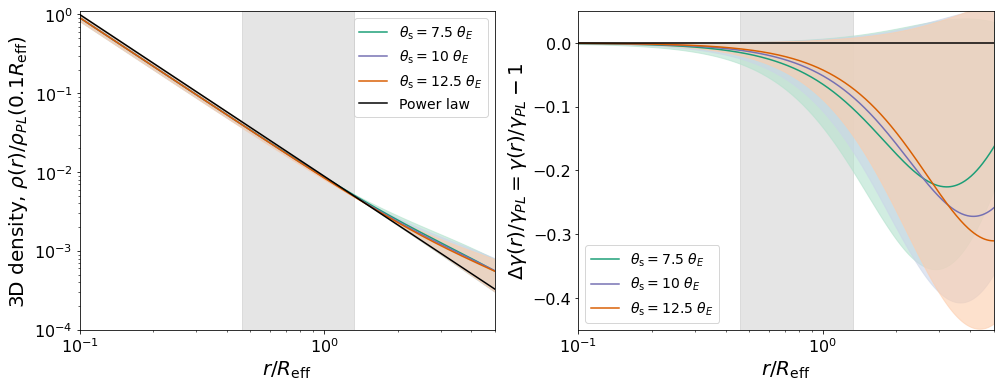

In [9]:
fig, (ax1, ax2 ) = plt.subplots(1, 2,  figsize=(14, 5.5))# figsize=(16, 6))

fill_index = 0
ax1.fill_betweenx([-2,20],[0.46,0.46],[1.33,1.33], color='gray',alpha=0.2)
for lamb in lambda_list:
    ax1.plot(xdata/R_eff,norm_factor*mst_rho(xdata,gamma,lambda_mst,theta_E,lamb*theta_E) ,
             label=r'$\theta_{\rm s} = $' + str(lamb) + ' ' + r'$ \theta_{E}$', color=line_color[fill_index])
    x1 = mst_rho(xdata,gamma,lambda_mst+lambda_err_up,theta_E,lamb*theta_E)
    x2 = mst_rho(xdata,gamma,lambda_mst-lambda_err_down,theta_E,lamb*theta_E) 
    ax1.fill_between(xdata/R_eff,norm_factor*x1,norm_factor*x2, color=fill_color[fill_index],alpha=0.6)
    fill_index += 1
ax1.plot(xdata/R_eff,norm_factor*power_law(xdata,gamma,theta_E) ,
         label='Power law', color='k')


ax1.axhline(0,color='k')
ax1.set_xlabel(r'$r/R_{\rm eff}}$', fontsize=20)
ax1.set_ylabel(r'3D density, $ \rho(r)/\rho_{PL}(0.1R_{\rm eff}) $',fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.1,5)
ax1.set_ylim(0.0001,1.1)
ax1.legend(fontsize=14)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)


plt.fill_betweenx([-2,2],[0.46,0.46],[1.33,1.33], color='gray',alpha=0.2)
for lamb in lambda_list:
    ax2.plot(xdata/R_eff,mst_gamma(xdata,gamma,lambda_mst,theta_E,lamb*theta_E)/gamma-1,
             label=r'$\theta_{\rm s} = $' + str(lamb) + ' ' + r'$ \theta_{E}$', color=line_color[fill_index])
    x1 = mst_gamma(xdata,gamma,lambda_mst+lambda_err_up,theta_E,lamb*theta_E)/gamma -1 
    x2 = mst_gamma(xdata,gamma,lambda_mst-lambda_err_down,theta_E,lamb*theta_E)/gamma -1 
    ax2.fill_between(xdata/R_eff,x1,x2, color=fill_color[fill_index],alpha=0.6)
    fill_index += 1

ax2.axhline(0,color='k')
ax2.set_xlabel(r'$r/R_{\rm eff}}$', fontsize=20)
ax2.set_ylabel(r'$\Delta \gamma (r) / \gamma_{PL} =  \gamma(r) / \gamma_{PL}  -1 $',fontsize=20)
ax2.legend(fontsize=14)
ax2.set_xlim(0.1,5)
ax2.set_ylim(-0.45,0.05)
ax2.set_xscale('log')
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
plt.tight_layout()

